In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Berger Viscous Equation parameters
c = 1.0    # Wave speed
mu = 0.1   # Viscosity coefficient
lam = 1.0  # Nonlinearity coefficient

# Define the neural network
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.net = nn.Sequential(*[
            nn.Sequential(nn.Linear(layers[i], layers[i+1]), nn.Tanh())
            for i in range(len(layers)-2)
        ] + [nn.Linear(layers[-2], layers[-1])])

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        return self.net(inputs)

# Generate collocation points
def generate_collocation_points(N_f, L=1.0, T=1.0):
    x_f = torch.rand(N_f, 1) * L  # x in [0, L]
    t_f = torch.rand(N_f, 1) * T  # t in [0, T]
    return x_f.to(device), t_f.to(device)

# Compute PDE residual using automatic differentiation
def compute_pde_residual(model, x, t):
    x.requires_grad = True
    t.requires_grad = True

    u = model(x, t)  # Predict u(x, t)
    
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u), create_graph=True)[0]
    
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]

    f = u_tt - c**2 * u_xx - mu * u_xx + lam * u * u_xx  # PDE residual
    return f

# Define loss function
def loss_function(model, x_f, t_f, x_bc, t_bc, u_bc):
    f_residual = compute_pde_residual(model, x_f, t_f)
    loss_pde = torch.mean(f_residual**2)

    u_pred_bc = model(x_bc, t_bc)
    loss_bc = torch.mean((u_pred_bc - u_bc)**2)

    return loss_pde + loss_bc

# Training loop
def train(model, optimizer, x_f, t_f, x_bc, t_bc, u_bc, epochs=5000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(model, x_f, t_f, x_bc, t_bc, u_bc)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Define PINN model architecture
layers = [2, 50, 50, 50, 1]  # Input (x,t) -> Hidden layers -> Output (u)
model = PINN(layers).to(device)

# Define boundary and initial conditions
N_f = 1000  # Collocation points
L, T = 1.0, 1.0  # Spatial and time limits

x_f, t_f = generate_collocation_points(N_f, L, T)

# Boundary conditions (u(x, 0) = sin(pi x), u(0, t) = 0, u(L, t) = 0)
N_bc = 100
x_bc = torch.linspace(0, L, N_bc).view(-1, 1).to(device)
t_bc = torch.zeros_like(x_bc).to(device)
u_bc = torch.sin(np.pi * x_bc.cpu()).to(device)  # Initial condition

# Train the model
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, x_f, t_f, x_bc, t_bc, u_bc, epochs=10000)

# Visualize results
x_test = torch.linspace(0, L, 100).view(-1, 1).to(device)
t_test = torch.linspace(0, T, 100).view(-1, 1).to(device)

x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
x_flat, t_flat = x_grid.flatten().view(-1, 1), t_grid.flatten().view(-1, 1)

u_pred = model(x_flat, t_flat).detach().cpu().numpy().reshape(100, 100)




/home/cadmin/anaconda3/envs/Data_Science_V2/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.5268009901046753
Epoch 500, Loss: 0.006720336154103279
Epoch 1000, Loss: 0.0015816325321793556
Epoch 1500, Loss: 0.0005215288838371634
Epoch 2000, Loss: 0.0020502537954598665
Epoch 2500, Loss: 0.00016093897284008563
Epoch 3000, Loss: 0.00010371866665082052
Epoch 3500, Loss: 7.067091792123392e-05
Epoch 4000, Loss: 5.117397813592106e-05
Epoch 4500, Loss: 7.528800779255107e-05
Epoch 5000, Loss: 0.0008807952399365604
Epoch 5500, Loss: 2.404428414592985e-05
Epoch 6000, Loss: 0.00010336650302633643
Epoch 6500, Loss: 3.498089063214138e-05
Epoch 7000, Loss: 3.2278316211886704e-05
Epoch 7500, Loss: 1.6976662664092146e-05
Epoch 8000, Loss: 1.602548945811577e-05
Epoch 8500, Loss: 1.5236146282404661e-05
Epoch 9000, Loss: 1.3824488632963039e-05
Epoch 9500, Loss: 1.2992192750971299e-05


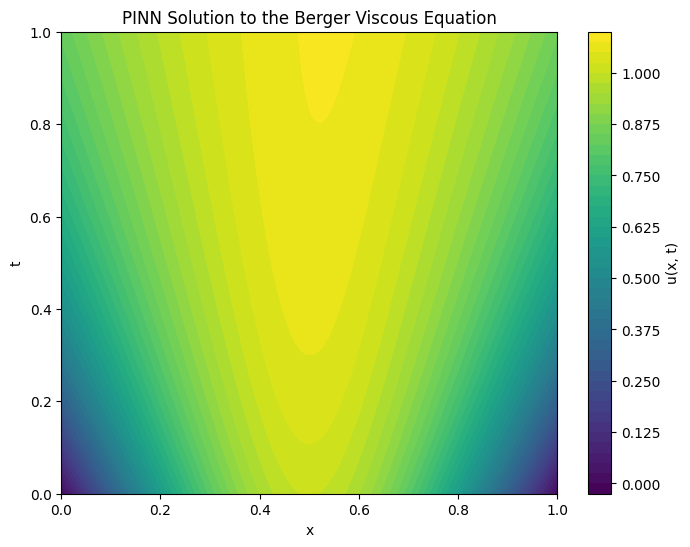

In [2]:
plt.figure(figsize=(8, 6))
plt.contourf(x_grid.cpu().numpy(), t_grid.cpu().numpy(), u_pred, levels=50, cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Solution to the Berger Viscous Equation")
plt.show()

In [19]:
x = torch.tensor([[0.5]]).to(device)
t = torch.tensor([[0.5]]).to(device)
u_pred = model(x, t).detach().cpu().numpy()

In [20]:
u_pred

array([[1.0643798]], dtype=float32)

In [22]:
u_pred

array([[-0.00119272,  0.01676596,  0.03447513, ...,  0.7875796 ,
         0.7901431 ,  0.79265195],
       [ 0.03178825,  0.04942479,  0.06679755, ...,  0.7932701 ,
         0.79567176,  0.7980204 ],
       [ 0.06454307,  0.08183929,  0.09885953, ...,  0.7987878 ,
         0.80102885,  0.8032186 ],
       ...,
       [ 0.06132293,  0.07991557,  0.09816825, ...,  0.82366836,
         0.8257633 ,  0.82779664],
       [ 0.02784315,  0.04681329,  0.06546625, ...,  0.8167978 ,
         0.81903756,  0.82121444],
       [-0.00583221,  0.01346929,  0.03248457, ...,  0.80970633,
         0.8120917 ,  0.814413  ]], dtype=float32)

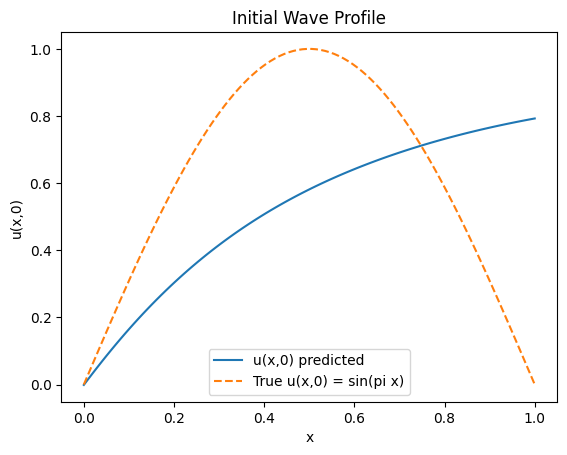

In [23]:
plt.plot(x_test.cpu().numpy(), u_pred[0], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()


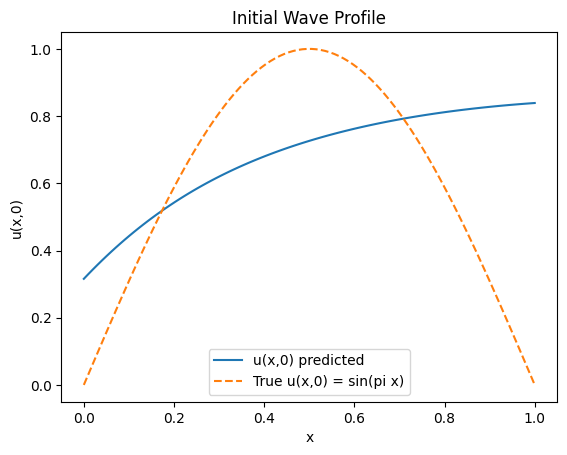

In [25]:
plt.plot(x_test.cpu().numpy(), u_pred[10], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()

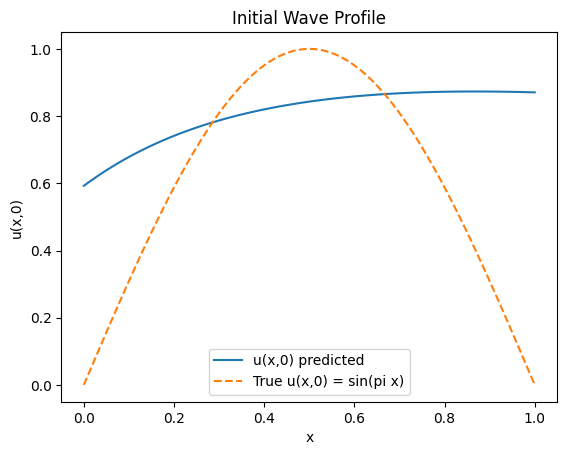

In [26]:
plt.plot(x_test.cpu().numpy(), u_pred[20], label="u(x,0) predicted")
plt.plot(x_test.cpu().numpy(), np.sin(np.pi * x_test.cpu().numpy()), '--', label="True u(x,0) = sin(pi x)")
plt.xlabel("x")
plt.ylabel("u(x,0)")
plt.title("Initial Wave Profile")
plt.legend()
plt.show()